## German Traffic Sign Classifier
Here, I have used the [German Traffic Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) to train and validate a model for classifying traffic sign images. I further tested my model on random German traffic signs found on the web.

I followed the structure of [Udacity CarND-Traffic-Sign-Classifier-Project](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project) for this purpose

---
## Step 0: Load The Data


In [0]:
# Load pickled data
import pickle
import cv2
import numpy as np
import csv
import math
import os
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary

### Basic Summary

In [0]:
all_labels = []

with open('signnames.csv', 'r') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    next(readCSV)

    for row in readCSV:
        all_labels += [row[1]]

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(all_labels))

print("Number of training examples =", n_train)
print("Number of Validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of Validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

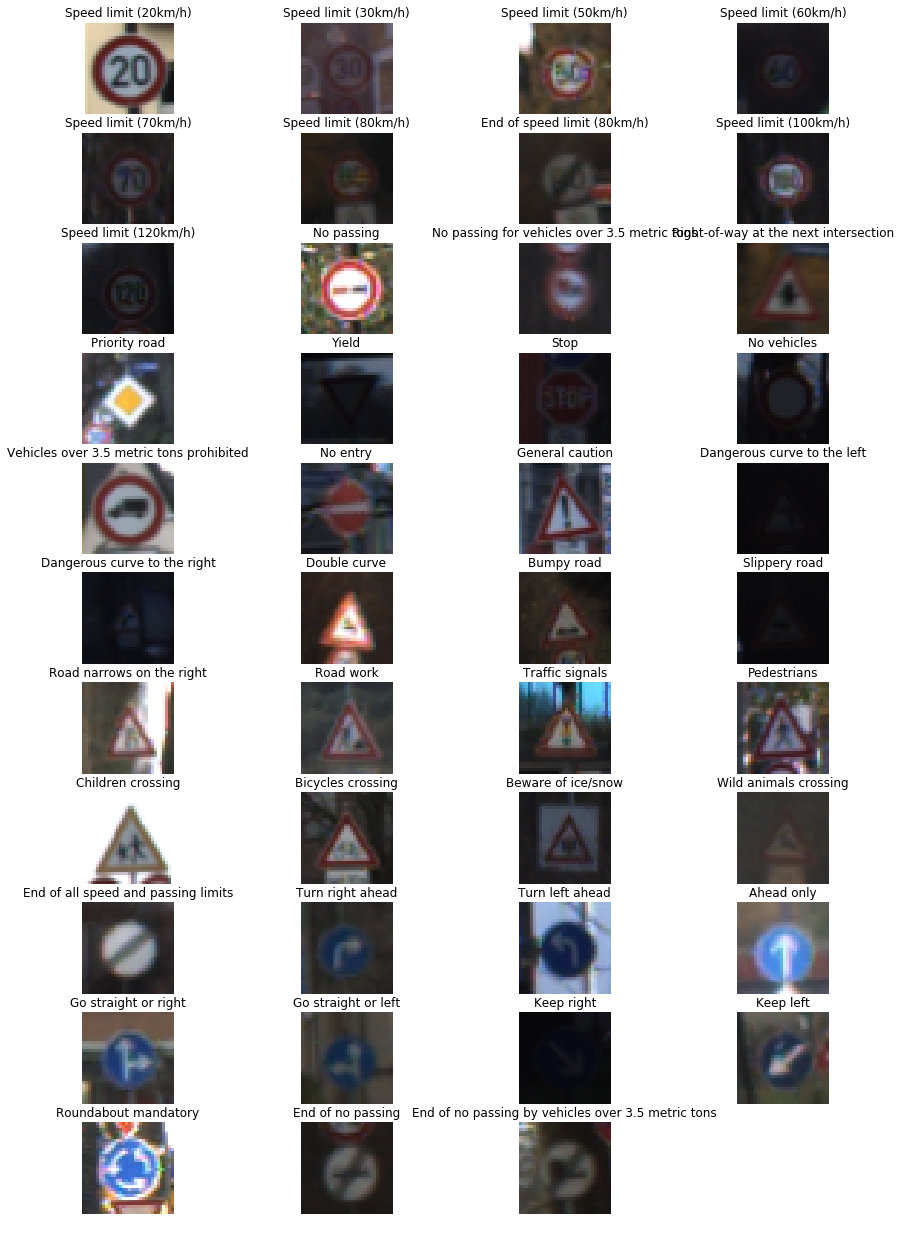

In [0]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline

num_of_samples=[]
plt.figure(figsize=(15, 30))
for i in range(0, n_classes):
    plt.subplot(15, 4, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(all_labels[i])
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()

Min number of images per class = 180
Max number of images per class = 2010


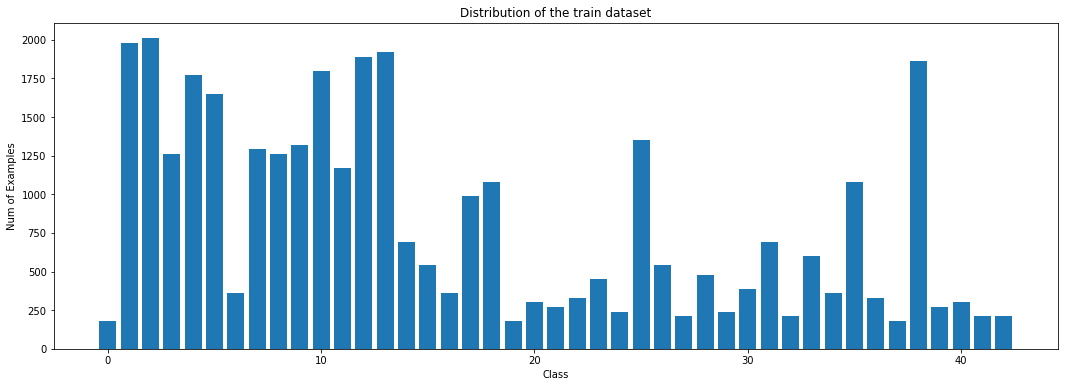

In [0]:
# Plot image type distribution

def plot_examples_per_class(labels_):
    values, counts = np.unique(labels_, return_counts=True)
    plt.figure(figsize=(18, 6))
    plt.bar(values, counts)
    plt.ylabel('Num of Examples')
    plt.xlabel('Class')
    plt.title("Distribution of the train dataset")
    
plot_examples_per_class(y_train)

print("Min number of images per class =", min(num_of_samples))
print("Max number of images per class =", max(num_of_samples))

----

## Step 2: Design and Test Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data. 


To generate additional training image, transform_image function isused, which incluides image Rotation, Sharing, and image Translations.

In [0]:
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img



Image data shape = (32, 32, 3)


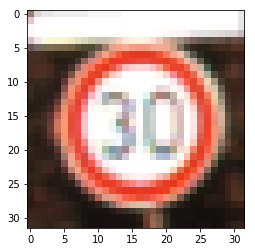

In [0]:
# Example image Without transformation
image_num=3000
image = X_train[image_num,:,:,:]
image = transform_image(image,0,0,0)
plt.imshow(image)
print("Image data shape =", image_shape)

Image data shape = (32, 32, 3)


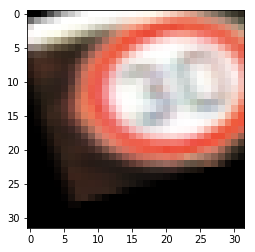

In [0]:
# Example image with transformation
image_num=3000
image = X_train[image_num,:,:,:]
image = transform_image(image,10,10,10)
plt.imshow(image)
print("Image data shape =", image_shape)

## Total number of images generated per class

    
***Running transform_images for all images***

In [0]:
values, counts = np.unique(y_train, return_counts=True)
max_counts = counts.max()

for class_ in values:

  # print('working on class #', class_, '...')

  num_img_needed = max_counts-counts[class_]

  first_example_index = next(index for index, val in enumerate(y_train) if val==class_)
  first_example = X_train[first_example_index]

  class_ = class_.reshape([1])
  
for num in range(0,num_img_needed):
  transformed_example = transform_image(first_example,5,5,5)
  transformed_example = transformed_example.reshape([1, 32, 32, 3])
  X_train = np.concatenate([X_train, transformed_example])
  y_train = np.concatenate([y_train, class_])

## Save the data for easy access


In [0]:
import os

pickle_file = 'transformed_data_2.pickle'

if not os.path.isfile(pickle_file):

    print('Saving data to pickle file...')
    try:
        with open('transformed_data_2.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'X_train': X_train,
                    'y_train': y_train,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


## Import New generated image data

In [0]:
# Reload the data
pickle_file = 'transformed_data_2.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['X_train']
    y_train = pickle_data['y_train']
    #del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.


In [0]:
print ("Number of training examples after image augument =",len(X_train))
print ("Number of testing examples after image augument =",len(X_test))
print ("Number of training labels after image augument =",len(y_train))
print ("Number of testing labels after image augument =",len(y_test))


Number of training examples after image augument = 36599
Number of testing examples after image augument = 12630
Number of training labels after image augument = 36599
Number of testing labels after image augument = 12630


## Training data splitting for validation dataset

Size of Validation data is 20% of training data.

In [0]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)


from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [0]:
print ("Number of training examples after data split =",len(X_train))
print ("Number of testing examples after data split =",len(X_test))
print ("Number of validation examples after data split =",len(X_valid))
print ("Number of training labels after data split =",len(y_train))
print ("Number of testing labels after data split =",len(y_test))
print ("Number of validation labels after data split =",len(y_valid))

Number of training examples after data split = 29279
Number of testing examples after data split = 12630
Number of validation examples after data split = 7320
Number of training labels after data split = 29279
Number of testing labels after data split = 12630
Number of validation labels after data split = 7320


## Data Preprocessing incluides converting images to grayscale and image normalization   with   (x-xmean/std ).

In [0]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def pre_process_image(image):
    image_gray = np.mean(image, axis=3)
    image_gray = np.expand_dims(image_gray, axis=3)
    image_norm = (image_gray - image_gray.mean())/image_gray.std()
    
    return image_norm

In [0]:
X_train = pre_process_image(X_train) 
X_valid = pre_process_image(X_valid) 
X_test = pre_process_image(X_test) 

Image data shape = (32, 32, 1)


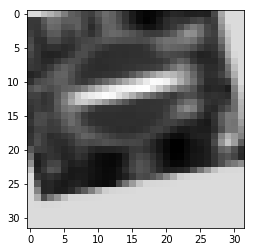

In [0]:
# Example transformation
image_num=3000
image = X_train[image_num,:,:,:]
image = transform_image(image,10,10,10)
plt.imshow(image, cmap='gray')
print("Image data shape =", X_train[image_num].shape)

## Model Architecture

In [0]:
import tensorflow as tf

EPOCHS = 70
BATCH_SIZE = 100

In [0]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1,name='convolution0')
    conv1 = tf.nn.dropout(conv1, keep_prob2)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='convolution1')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2, name='convolution2')

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='convolution3')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Dropout_01    
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    #Dropout_02
    fc2 = tf.nn.dropout(fc2, keep_prob)


    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma, name='weights'))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels
x is a placeholder for a batch of input images.
y is a placeholder for a batch of output labels.

In [0]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
keep_prob2 = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [0]:
rate = 0.0009

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [0]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0, keep_prob2:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    validation_accuracy_figure = []

    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.6, keep_prob2:0.7})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_figure.append(validation_accuracy)

        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './Traffic')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.730

EPOCH 2 ...
Validation Accuracy = 0.853

EPOCH 3 ...
Validation Accuracy = 0.895

EPOCH 4 ...
Validation Accuracy = 0.937

EPOCH 5 ...
Validation Accuracy = 0.945

EPOCH 6 ...
Validation Accuracy = 0.961

EPOCH 7 ...
Validation Accuracy = 0.963

EPOCH 8 ...
Validation Accuracy = 0.967

EPOCH 9 ...
Validation Accuracy = 0.971

EPOCH 10 ...
Validation Accuracy = 0.975

EPOCH 11 ...
Validation Accuracy = 0.979

EPOCH 12 ...
Validation Accuracy = 0.980

EPOCH 13 ...
Validation Accuracy = 0.982

EPOCH 14 ...
Validation Accuracy = 0.982

EPOCH 15 ...
Validation Accuracy = 0.984

EPOCH 16 ...
Validation Accuracy = 0.983

EPOCH 17 ...
Validation Accuracy = 0.982

EPOCH 18 ...
Validation Accuracy = 0.984

EPOCH 19 ...
Validation Accuracy = 0.985

EPOCH 20 ...
Validation Accuracy = 0.986

EPOCH 21 ...
Validation Accuracy = 0.987

EPOCH 22 ...
Validation Accuracy = 0.989

EPOCH 23 ...
Validation Accuracy = 0.988

EPOCH 24 ...
Validation Accura

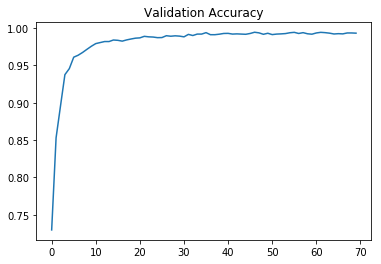

In [0]:
plt.plot(validation_accuracy_figure)
plt.title("Validation Accuracy")
plt.show()

In [0]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Valid Accuracy = {:.3f}".format(valid_accuracy))    
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

W0728 05:42:48.394006 140144129525632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Train Accuracy = 0.999
Valid Accuracy = 0.993
Test Accuracy = 0.951


---

## Step 3: Testing on Random online Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

In [0]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
!mkdir custom

(4, 32, 32, 1)


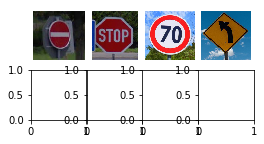

In [0]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#reading in an image
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,4, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./custom/*.jpg')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #image = np.expand_dims(cv2.resize(image, (32, 42)), axis=0)
    image = cv2.resize(image, (32, 32))
    my_images.append(image)

my_images_normalized=pre_process_image(my_images)
print(my_images_normalized.shape)

In [0]:
### Run the predictions

my_labels = [17, 14, 4, 34]


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./Traffic.meta')
    saver3.restore(sess, "./Traffic")
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

Test Set Accuracy = 0.750


### Predict the Sign Type for Each Image

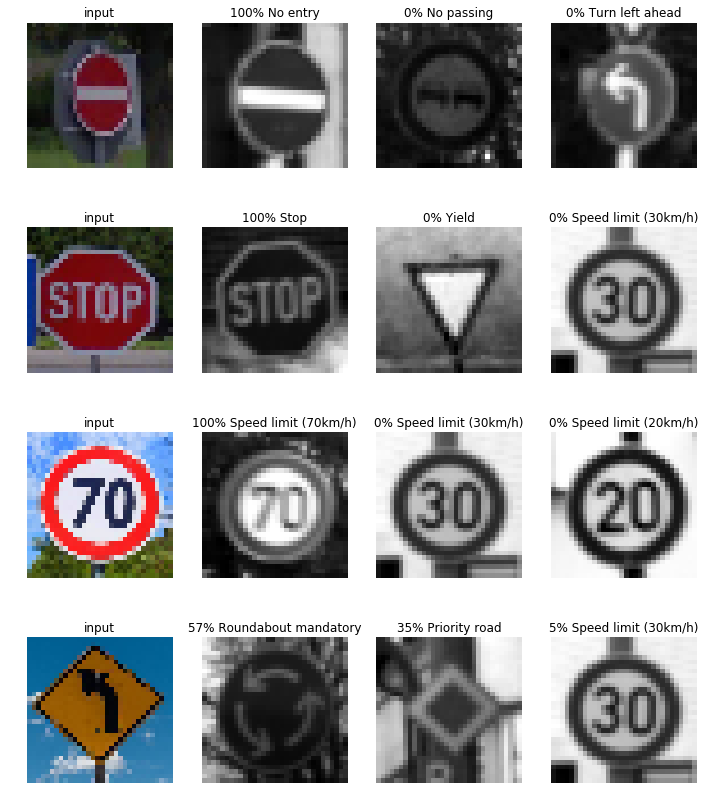

In [0]:
### Visualize the softmax probabilities

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./Traffic.meta')
    saver.restore(sess, "./Traffic")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_normalized, keep_prob: 1.0, keep_prob2:1.0})
    my_top_k = sess.run(top_k, feed_dict={x: my_images_normalized, keep_prob: 1.0, keep_prob2:1.0})

    
    fig, axs = plt.subplots(len(my_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')

        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_valid[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('{:.0f}% {}'.format(100*my_top_k[0][i][0], all_labels[guess1]))
        
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_valid[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('{:.0f}% {}'.format(100*my_top_k[0][i][1], all_labels[guess2]))
        
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_valid[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('{:.0f}% {}'.format(100*my_top_k[0][i][2], all_labels[guess3]))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

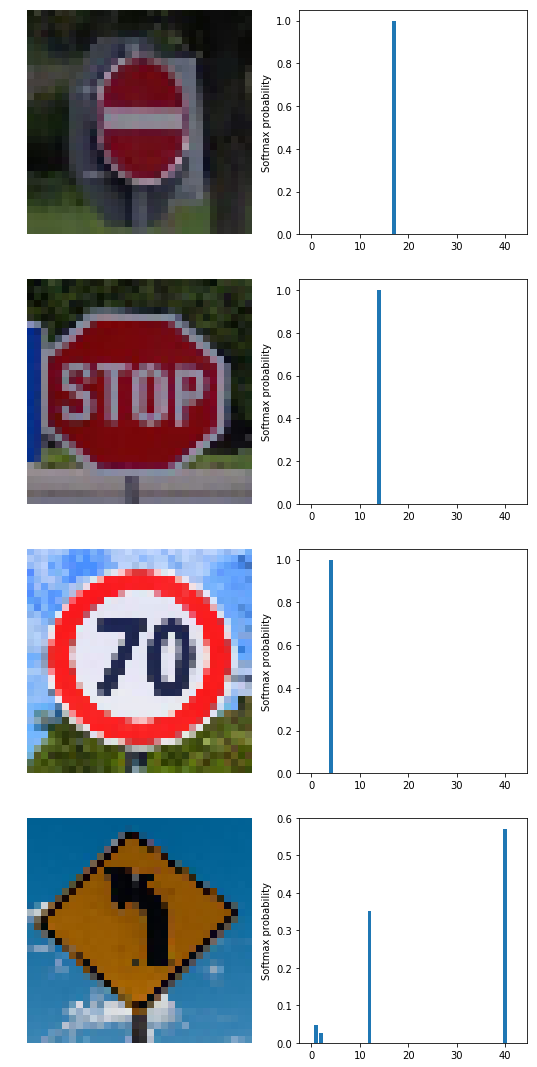

In [0]:
fig, axs = plt.subplots(4,2, figsize=(9, 19))
axs = axs.ravel()

for i in range(len(my_softmax_logits)*2):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(cv2.cvtColor(my_images[i//2], cv2.COLOR_BGR2RGB))
    else:
        axs[i].bar(np.arange(n_classes), my_softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Softmax probability')

---

## Visualize the Neural Network's State with Test Images

While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. 

After successfully training the neural network we can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. 

From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.



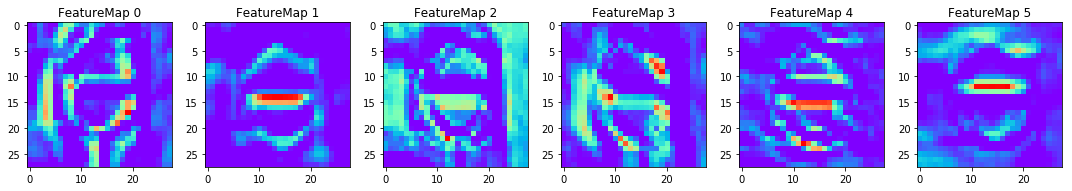

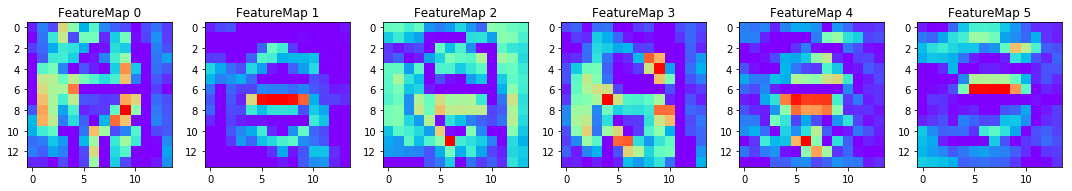

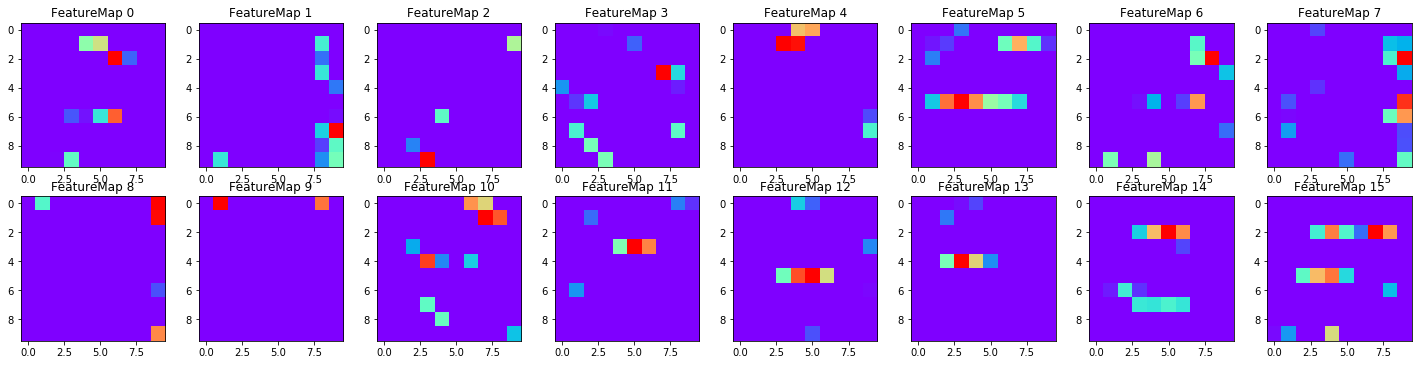

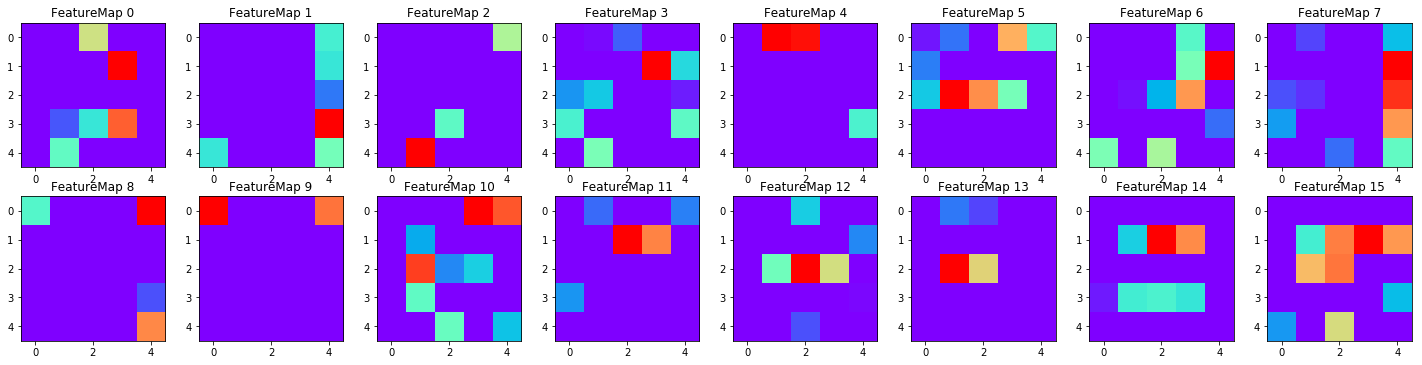

In [0]:
### Visualize your network's feature maps here.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x: my_images_normalized, keep_prob: 1.0, keep_prob2:1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(25,25))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="rainbow")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap='rainbow')
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap='rainbow')
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap='rainbow')
            

with tf.Session() as sess:

    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv1 = sess.graph.get_tensor_by_name('convolution0:0')
    outputFeatureMap(my_images_normalized,conv1, activation_min=-1, activation_max=-1, plt_num=1)
    
    conv1 = sess.graph.get_tensor_by_name('convolution1:0')
    outputFeatureMap(my_images_normalized,conv1, activation_min=-1, activation_max=-1, plt_num=2)
    
    conv2 = sess.graph.get_tensor_by_name('convolution2:0')
    outputFeatureMap(my_images_normalized,conv2, activation_min=-1, activation_max=-1, plt_num=3)
    
    conv2 = sess.graph.get_tensor_by_name('convolution3:0')
    outputFeatureMap(my_images_normalized,conv2, activation_min=-1, activation_max=-1, plt_num=4)
        
    